# Prediction of Ransome Activity 

Rihem Mansri, Mohamed Issa, Mootez Dakhlaoui, Bourhan Dernayka, Joel Pascal Soffo, Ronny Tonato

In [1]:
import os
import warnings
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import pdb
import datetime
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, log_loss, plot_roc_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib
from prettytable import PrettyTable
from pprint import pprint

warnings.filterwarnings("ignore")

## **Importing Data**

In [2]:
data = pd.read_csv("BitcoinHeistData.csv")
data.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


In [3]:
# Global view for the data
data.describe()

,year,day,length,weight,count,looped,neighbors,income
count,879730.000000,879730.000000,879730.000000,8.797300e+05,879730.000000,879730.000000,879730.000000,8.797290e+05
mean,2011.865744,167.881771,25.623141,5.219976e-01,145.729969,34.485173,2.298332,1.019119e+10
std,0.998424,106.295965,41.601932,2.854665e+00,587.820566,282.088273,18.855091,2.782442e+11
min,2011.000000,1.000000,0.000000,3.606469e-94,1.000000,0.000000,1.000000,3.000000e+07
25%,2011.000000,75.000000,0.000000,1.596467e-02,1.000000,0.000000,1.000000,1.131351e+08
50%,2012.000000,156.000000,4.000000,2.500000e-01,1.000000,0.000000,2.000000,5.500000e+08
75%,2012.000000,261.000000,28.000000,5.352858e-01,10.000000,0.000000,2.000000,2.970481e+09
max,2018.000000,365.000000,144.000000,4.982885e+02,13462.000000,11693.000000,3776.000000,4.996440e+13


In [4]:
print(data.shape)

(879730, 10)


Our dataset has roughly 2,000,000 rows and 10 columns. Out of these 10 columns, we have 9 predictors and one target column. Each row details a particular transaction with 9 features.

Description of features : .................


## **Data Cleaning and Feature Engineering**

In [5]:
for i in list(data.columns):
    if any(data[i].isnull()):
        print('Column: {} contains NaN'.format(i))
    else:
        print('No NaN found...')

No NaN found...
No NaN found...
No NaN found...
No NaN found...
No NaN found...
No NaN found...
No NaN found...
No NaN found...
Column: income contains NaN
Column: label contains NaN


as we can see there are many columns containing NaN values so the easiest way is to drop those lines.

In [6]:
data.dropna(inplace=True)
data = data.drop_duplicates()  #Drop duplicate Rows

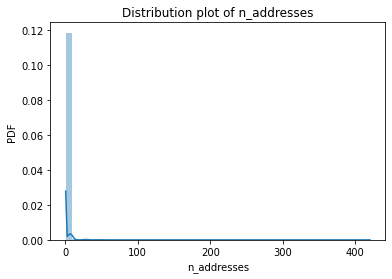

In [7]:
data['address'].value_counts()
n_addresses = list(data['address'].value_counts())

#plot to print distribution of n_addresses
plt.title('Distribution plot of n_addresses')
sns.distplot(n_addresses)
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

In [8]:
print('An address is repeated an average of {} number of times'.format(np.mean(n_addresses)))

An address is repeated an average of 1.2608661378952528 number of times


We get an extremely skewed distribution, hence we will try to zoom-in for better inference so we will plot only points in the 5th percentile

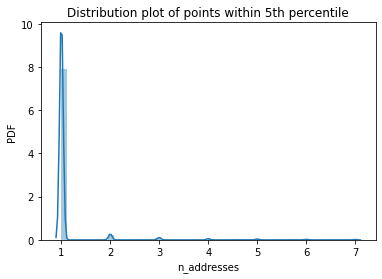

In [9]:
fifth_per = np.percentile(n_addresses, 99)
n_addresses_fifthpercentile = np.array([element for element in n_addresses if element <=fifth_per ])
#checking points only within 5th percentile

plt.title('Distribution plot of points within 5th percentile')
sns.distplot(n_addresses_fifthpercentile)
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

We see that most addresses are repeated only once and a small percentage of them are repeated twice and even a smaller number for the addresses repeated 3 times

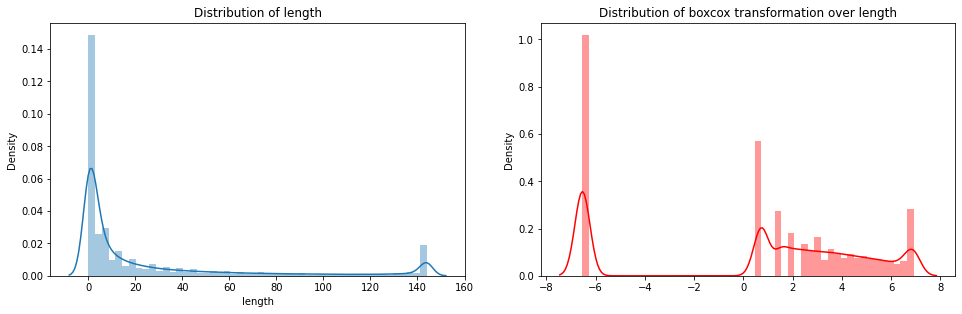

In [10]:
# Looking at its distribution
plt.figure(figsize=(14, 5))


plt.subplot(121)
sns.distplot(data['length'])
plt.title('Distribution of length')


plt.subplot(122)
sns.distplot(boxcox(np.array(data['length']) + 1e-6)[0], color='red')
plt.title('Distribution of boxcox transformation over length')

plt.tight_layout(pad=3.0)
plt.show()


In global view we can see that we have a skewness in mostly all features so to have a better modelling in our algorithm we are trying to fix the skewness and that's by doing complex functions like Sin/ Log and performing a boxcox operation on it.

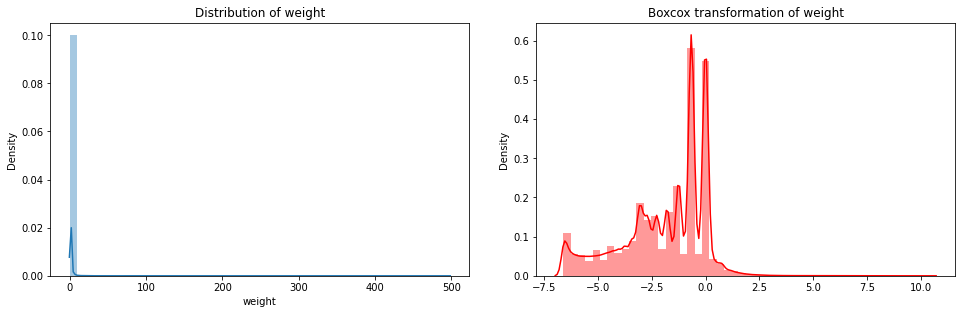

In [11]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
sns.distplot(data['weight'])
plt.title('Distribution of weight')

plt.subplot(122)
sns.distplot(boxcox(np.array(data['weight']))[0], color='red')
plt.title('Boxcox transformation of weight')

plt.tight_layout(pad=3.0)
plt.show()

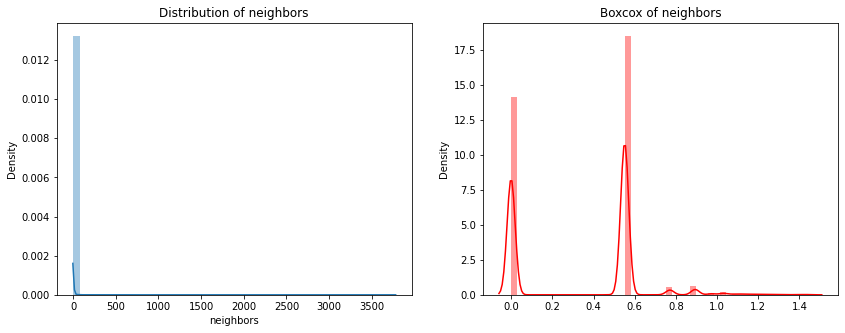

In [12]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
sns.distplot(data['neighbors'])
plt.title('Distribution of neighbors')

plt.subplot(122)
sns.distplot(boxcox(np.array(data['neighbors']) + 1e-6)[0], color='red')
plt.title('Boxcox of neighbors')
plt.show()

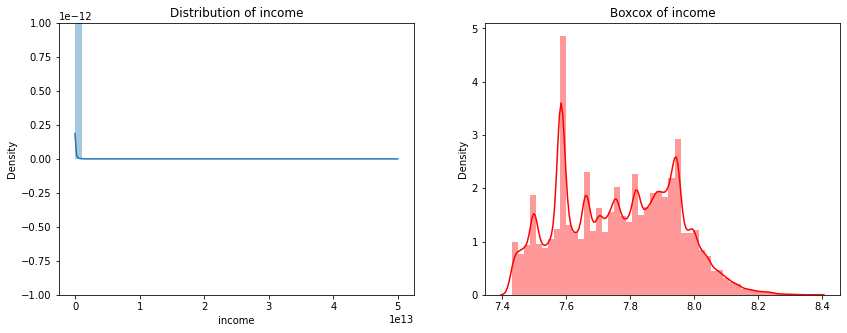

In [13]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
sns.distplot(data['income'])
plt.title('Distribution of income')

plt.subplot(122)
sns.distplot(boxcox(np.array(data['income']) + 1e-6)[0], color='red')
plt.title('Boxcox of income')
plt.show()

As we can see doing some transformation on the data makes it more suitable for algorithms. showing more guassian distributions will help in modelling.

### Goal of using boxcox : 
Linear Regression, Gaussian Naive Bayes and other type of algorithms for classification are machine learning techniques that assume numerical variables have a Gaussian probability distribution.
Our data might have a Gaussian-like distribution (e.g. almost Gaussian but with outliers or a skew) or a completely different distribution from a Gaussian distribution (e.g. exponential).
As a result, by changing input and/or output variables to have a Gaussian or more-Gaussian distribution, you may be able to improve performance on a wide range of machine learning techniques.

=> we will add other features of those transformations

we can add also interaction features between the income and the neighbors which will represent complex features for the model that explains the correlation between both of them when comparing to each one mean

In [14]:
def get_income_neighbors(income, neighbor):
    """If botg of them is greater than the median then return 0
        if only income is greater than median return 1
        else return 2"""
    
    if income > median_income:
        if neighbor > median_neighbors:
            return 0
        else:
            return 1
    return 2

In [15]:
median_neighbors = np.median(data['neighbors'])
median_income = np.median(data['income'])

interaction_income_neighbors = []
for indice, ligne in tqdm(data.iterrows(), total=data.shape[0]):
    interaction_income_neighbors.append(get_income_neighbors(ligne['income'], ligne['neighbors']))


  0%|          | 0/879729 [00:00<?, ?it/s]

In [16]:
def get_day_number(First_day, day_i):
    #return day number (0 for monday, 6 for sunday) for day_i
    return (First_day + day_i - 1) % 7

data_day_of_week = np.array([])
for indice, ligne in tqdm(data.iterrows()):
    year_i, day_i = ligne['year'], ligne['day']
    data_day_of_week = np.append(data_day_of_week, get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

0it [00:00, ?it/s]

In [17]:
interaction_income_neighbors = np.array(interaction_income_neighbors)
data_gaussian_weight = boxcox(np.array(data['weight']) + 1e-6)[0]
data_gaussian_length = boxcox(np.array(data['length']) + 1e-6)[0]
data_gaussian_neighbors = boxcox(np.array(data['neighbors']) + 1e-6)[0]
data_gaussian_income = boxcox(np.array(data['income']) + 1e-6)[0]

# Adding features
data["data_gaussian_weight"] = data_gaussian_weight
data["data_gaussian_length"] = data_gaussian_length
data["data_gaussian_neighbors"] = data_gaussian_neighbors
data["data_gaussian_income"] = data_gaussian_income
data["interaction_income_neighbors"] = interaction_income_neighbors
data["data_day_of_week"] = data_day_of_week



In [18]:
data.head()

,address,year,day,length,weight,count,looped,neighbors,income,label,data_gaussian_weight,data_gaussian_length,data_gaussian_neighbors,data_gaussian_income,interaction_income_neighbors,data_day_of_week
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber,-3.067577e+00,3.488424,5.513356e-01,7.582943,2,2.0
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky,-4.025829e+00,4.851519,9.999992e-07,7.582885,2,2.0
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber,9.999996e-07,-6.534919,5.513356e-01,7.660858,2,4.0
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber,-3.334484e+00,5.670965,5.513356e-01,7.542315,2,3.0
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky,-2.033733e+00,6.914174,9.999992e-07,7.660858,2,3.0


we have 2 types of columns ones needs to be standerdized and the other needs to be encoded like interaction_income_neighbors/ data_day_of_week

### Scale the data

In [19]:
data.columns

Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'label', 'data_gaussian_weight',
       'data_gaussian_length', 'data_gaussian_neighbors',
       'data_gaussian_income', 'interaction_income_neighbors',
       'data_day_of_week'],
      dtype='object')

In [20]:
col_names_standardize = [
    'year', 'day', 'length', 'weight', 'count', 'looped',
    'neighbors', 'income', 'data_gaussian_weight',
    'data_gaussian_length', 'data_gaussian_neighbors',
    'data_gaussian_income']
col_names_Encode = [
       'interaction_income_neighbors',
       'data_day_of_week']


transformer = ColumnTransformer([
    ('standardize', StandardScaler(), col_names_standardize),
    ('encode', OneHotEncoder(), col_names_Encode)])

transformer.fit(data)
Data_scaled_Transformed = transformer.transform(data)

In [21]:
pd.DataFrame(Data_scaled_Transformed).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,5.142366,-1.475897,-0.183240,-0.179939,-0.246215,-0.12225,-0.015822,-0.036267,-0.900112,0.608309,0.671443,-1.013729,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,4.140786,-0.337565,0.441731,-0.182772,-0.246215,-0.12225,-0.068859,-0.036267,-1.501462,0.896093,-1.141657,-1.014059,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.140786,0.734912,-0.615912,0.167446,-0.246215,-0.12225,-0.015822,-0.035908,1.024941,-1.507872,0.671443,-0.574695,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.140786,1.449897,1.114777,-0.181489,-0.246215,-0.12225,-0.015822,-0.036371,-1.067609,1.069098,0.671443,-1.242666,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4.140786,0.659650,2.845466,-0.157339,0.527831,-0.12225,-0.068859,-0.035908,-0.251325,1.331571,-1.141657,-0.574695,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Feature indicates what year the transaction had taken place in.

Now let us look at its distribution and how it affects the target variable.

## Day

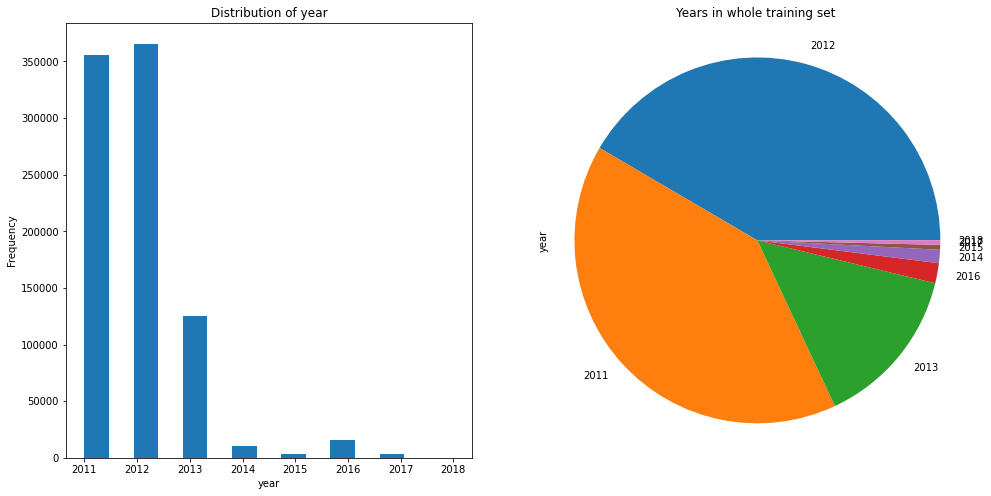

In [38]:
#Displaying histogram of year feature
plt.figure(figsize=(16, 8))

plt.subplot(121)
data['year'].plot(kind = 'hist', bins=15)
plt.xlabel('year')
plt.title('Distribution of year')

plt.subplot(122)
#displaying pie-chart
data['year'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Years in whole training set')
plt.show()


we can see that the years are not distributed uniformly the majority are present in early years from 2011-2013

In [50]:
# Splitting data two white and ransomware in order to have a general view on the distribution of the features
Ransomware = data[data['label']!= "white"]
clean = data[data['label']=="white"]

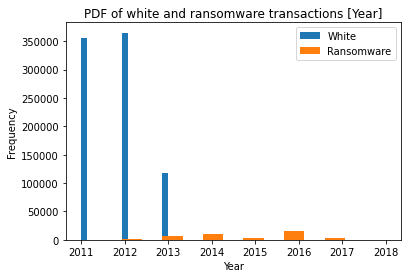

In [51]:
#checking to see if the year in which the transaction has been made has any correlation with the transaction

clean['year'].plot(kind = 'hist', bins=15, label='White')
Ransomware['year'].plot(kind = 'hist', bins=15, label='Ransomware')
plt.xlabel('year')
plt.title('PDF of white and ransomware transactions [Year]')
plt.xlabel('Year')
plt.legend()
plt.show()

Transactions made in 2011 and 2012 are far more likely to be white rather than ransomware and for the rest the majority is ransomware

## Day

**The day number of the year in which the transaction took place is shown by this feature.**

**Now consider its distribution and how it influences the target variable.**

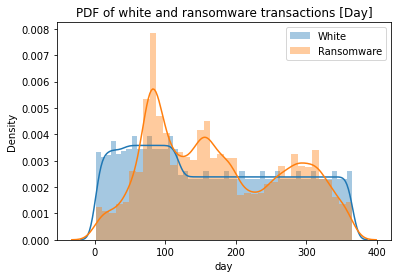

In [52]:
#plotting pdfs of white and ransomware

sns.distplot(clean['day'], label = 'White')
sns.distplot(Ransomware['day'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Day]')
plt.show()

On certain days, the two roles appear to be separable. On day 95, for example, ransomeware transactions are considerably more probable than white transactions.
it is the same for the days around 150 and 300.

### Length

The mixing rounds on Bitcoin are when transactions receive and distribute comparable sums of bitcoin in numerous rounds using freshly established addresses in order to conceal the coin's origin.
Now consider its distribution and how it influences the target variable.

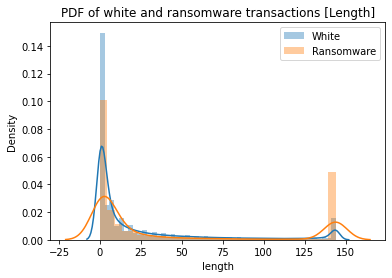

In [53]:
#plotting pdfs of white and ransomware

sns.distplot(clean['length'], label = 'White')
sns.distplot(Ransomware['length'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Length]')
plt.show()

we can see here that the distribtion of both the White and Ransomware data are indistinguishable so we can not separate well the target using only the Length feature. 

### Neighbors

The number of neighbors a transaction had is shown by this feature.
Now consider its distribution and how it influences the target variable.


[]

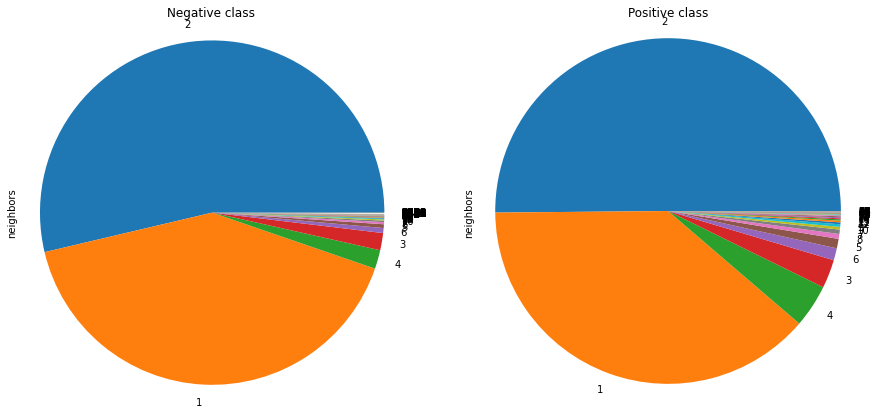

In [60]:
plt.figure(figsize=(15, 7))

#plotting piechart of negative class
plt.subplot(121)
clean.neighbors.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Negative class')
plt.plot()


plt.subplot(122)
Ransomware.neighbors.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Positive class')
plt.plot()

it is clear from the pies that the ransomeware and clean datasets follow different distributions on the neighbors features

### Day of the week


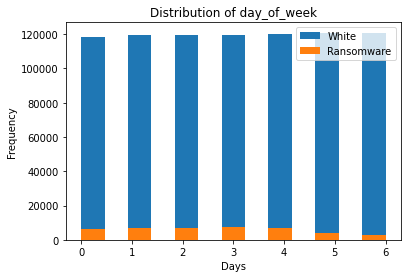

In [64]:
#Displaying histogram of day_of_week feature

clean['data_day_of_week'].plot(kind = 'hist', bins=13, label='White')
Ransomware['data_day_of_week'].plot(kind = 'hist', bins=13, label='Ransomware')
plt.xlabel('data_day_of_week')
plt.title('Distribution of day_of_week')
plt.xlabel('Days')
plt.legend()
plt.show()

From the data available we can deduce that the Ransomeware activity is the lowest on the Sundays but on the other days it is still present with the same rate across all the week

## Gaussian income

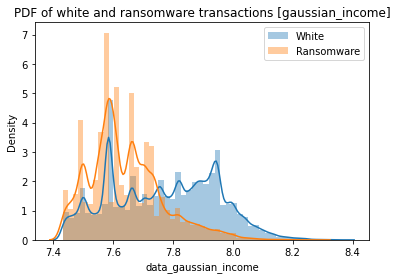

In [66]:
sns.distplot(clean['data_gaussian_income'], label = 'White')
sns.distplot(Ransomware['data_gaussian_income'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [gaussian_income]')
plt.show()

There is a significant difference between the two distributions. so this will be a huge plus in our modelling especially when starting from 7.8

In [67]:
clean.columns

Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'label', 'data_gaussian_weight',
       'data_gaussian_length', 'data_gaussian_neighbors',
       'data_gaussian_income', 'interaction_income_neighbors',
       'data_day_of_week'],
      dtype='object')

## Interaction: income and neighbors

The feature was created by combining and applying transformation functions to income and neighbors. Let's have a look at how it impacts our main variable.

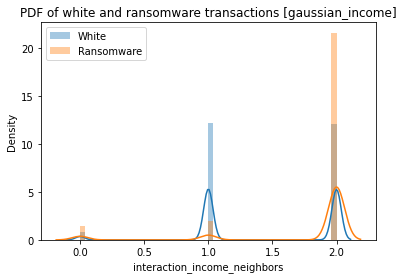

In [68]:
sns.distplot(clean['interaction_income_neighbors'], label = 'White')
sns.distplot(Ransomware['interaction_income_neighbors'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [gaussian_income]')
plt.show()

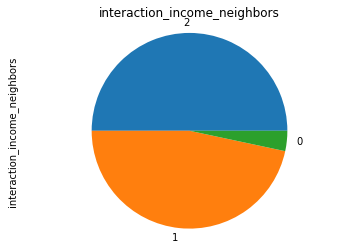

In [69]:
#displaying pie-chart

data['interaction_income_neighbors'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('interaction_income_neighbors')
plt.show()

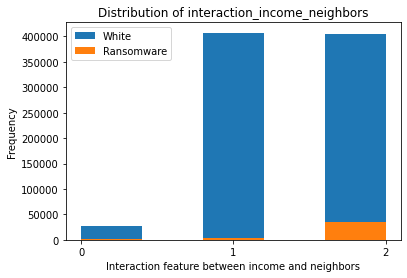

In [70]:
clean['interaction_income_neighbors'].plot(kind = 'hist', bins=5, label='White')
Ransomware['interaction_income_neighbors'].plot(kind = 'hist', bins=5, label='Ransomware')
plt.xlabel('interaction_income_neighbors')
plt.title('Distribution of interaction_income_neighbors')
plt.xlabel('Interaction feature between income and neighbors')
plt.xticks([0, 1, 2])
plt.legend()
plt.show()

Transactions with this feature being equal to 0 and 1 is significanly more probable to be white than ransomware

# Multi-variate Analysis



## Correlations
A measure of the strength of a linear link between two quantitative variables is called correlation (e.g., height, weight).

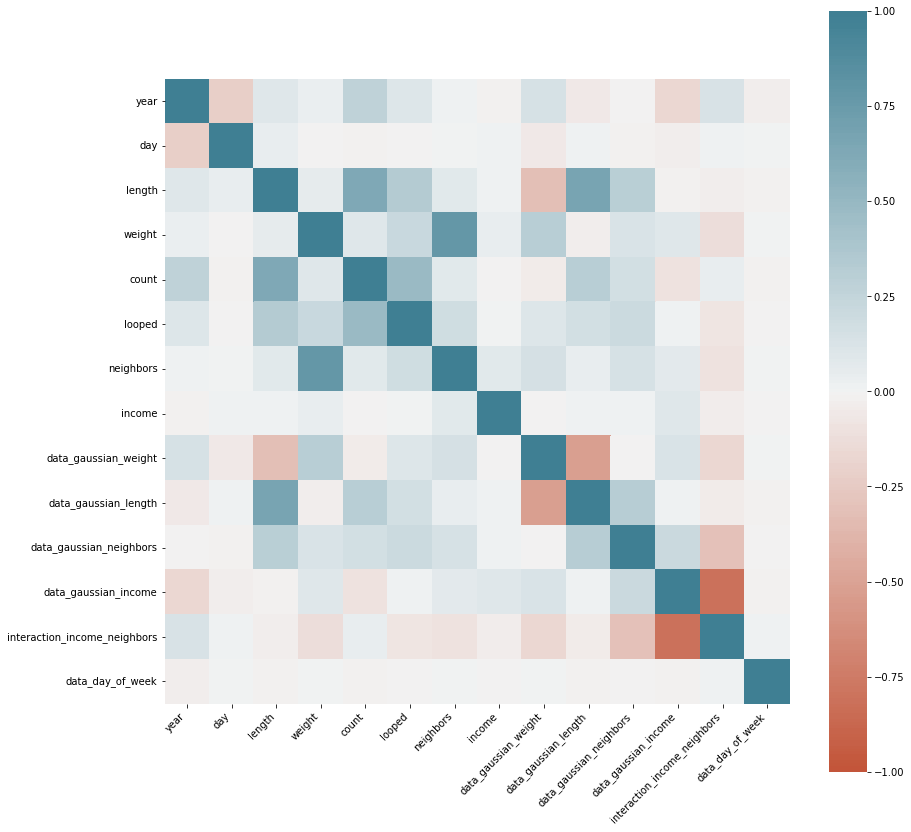

In [71]:
#plotting correlation map
# +1 and -1 mean fully-correlated features

corr = data.corr()
plt.figure(figsize=(14, 14))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Pair plots

Pairs plots show how a feature's points are distributed in relation to other features.

In [ ]:
#plotting pair plots

sns.set_theme(style='ticks')
sns.pairplot(data, hue='label')
plt.title('Pair-plot')
plt.plot()

In [73]:
data.columns

Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'label', 'data_gaussian_weight',
       'data_gaussian_length', 'data_gaussian_neighbors',
       'data_gaussian_income', 'interaction_income_neighbors',
       'data_day_of_week'],
      dtype='object')